In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
from __future__ import division
import seaborn as sns
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import sys
import graphlab
import unicodedata
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
sns.set_context({'figure.figsize': [12, 7]})
sns.set_context(rc={'lines.markeredgewidth': 0.1})
sns.set_style('white')
sns.set_color_codes()
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.utils import resample
print 'startup script successful'

Populating the interactive namespace from numpy and matplotlib


startup script successful


In [2]:
from nltk.stem import WordNetLemmatizer
import re
token_pattern = re.compile(r"(?u)\b\w\w+\b")

from nltk.corpus import stopwords
stop_list=stopwords.words('english')+['help','new', 'way', 'world', 'make', 'people', 'wa', 'ha', 'let', 'get', 'time', 'data']

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in token_pattern.findall(doc)]

def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def plot_top_words(model, feature_names, topic_idx, n_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
    topic=normalize(model.components_[topic_idx].reshape(1,-1))[0]
    sorted_idx=topic.argsort()[:-n_top_words - 1:-1]
    print("Topic #%d:" % topic_idx)
    features=[feature_names[i] for i in sorted_idx]
    print(" ".join(features))
    ax = sns.barplot(x=range(10),y=topic[sorted_idx])
    feature_id=0
    height= max(topic[sorted_idx])*0.6

    for p in ax.patches:
        ax.text(p.get_x()+0.15, height, '{}'.format(features[feature_id]))
        feature_id+=1

In [3]:
crunch_data=pd.read_csv('overall_company_list.csv')
kickstart_data=pd.read_csv('proj_list_tech_top200pages_full.csv')
angellist_data=pd.read_csv('results_so_far_2016101710pm.csv')
# unify the column name
kickstart_data.rename(columns={'description':'Description'},inplace=True)
angellist_data.rename(columns={'product_desc':'Description'},inplace=True)
#merge data
merge_data=crunch_data.append([kickstart_data,angellist_data])
# remove \n from descriptions
merge_data['Description']=merge_data['Description'].str.replace('\n',' ')
merge_data=merge_data.dropna(subset=['Description'])

In [4]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=2,
                                max_features=3000,
                                tokenizer=LemmaTokenizer(),
                                stop_words=stop_list)
tf = tf_vectorizer.fit_transform(merge_data['Description'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [5]:
i=10
print "original description"
print merge_data.iloc[i]['Description']
print "number of features", tf[i].sum()
print "extracted features"
print [tf_feature_names[idx] for idx in list(tf[i].nonzero()[1])] 

original description
Nanigans advertising automation software powers the world’s leading in-house performance marketing teams.
number of features 9
extracted features
[u'team', u'performance', u'house', u'leading', u'software', u'automation', u'advertising', u'power', u'marketing']


In [6]:
# build the LDA model

In [7]:
lda = LatentDirichletAllocation(n_topics=15, max_iter=200,
                                learning_method='batch',
                                learning_offset=50.,
                                random_state=0,n_jobs=-1, verbose=1)
lda.fit(tf)
topic_feature=lda.transform(tf)
topic_feature_norm=normalize(topic_feature)

(array([   32.,   348.,  2220.,  4350.,  4828.,  3300.,  2212.,  1453.,
         1285.,   563.]),
 array([ 0.06666667,  0.15858586,  0.25050504,  0.34242423,  0.43434342,
         0.52626261,  0.6181818 ,  0.71010099,  0.80202018,  0.89393937,
         0.98585856]),
 <a list of 10 Patch objects>)

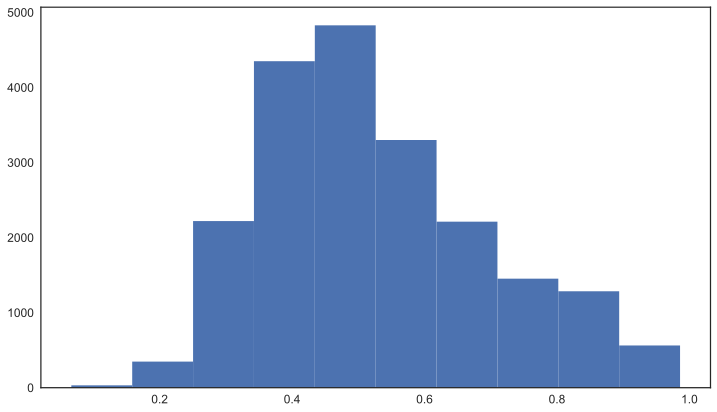

In [8]:
hist(np.max(topic_feature,axis=1))

Topic #0:
share video search friend social user photo find network discover
Topic #1:
smart device open first control source sensor power system arduino
Topic #2:
online business product consumer store marketplace payment service local market
Topic #3:
health care job patient cost company problem platform healthcare service
Topic #4:
customer email easy use team sale business work user one
Topic #5:
com http www 3d real estate reality target printer print
Topic #6:
app android mobile io next iphone event apps phone video
Topic #7:
food better design day restaurant one quality order idea made
Topic #8:
learning student machine decision platform tool technology science learn build
Topic #9:
mobile user based platform application web app location apps game
Topic #10:
platform social brand content marketing medium customer digital engagement audience
Topic #11:
home car music travel kid city fun experience child first
Topic #12:
analytics company intelligence business technology big servic

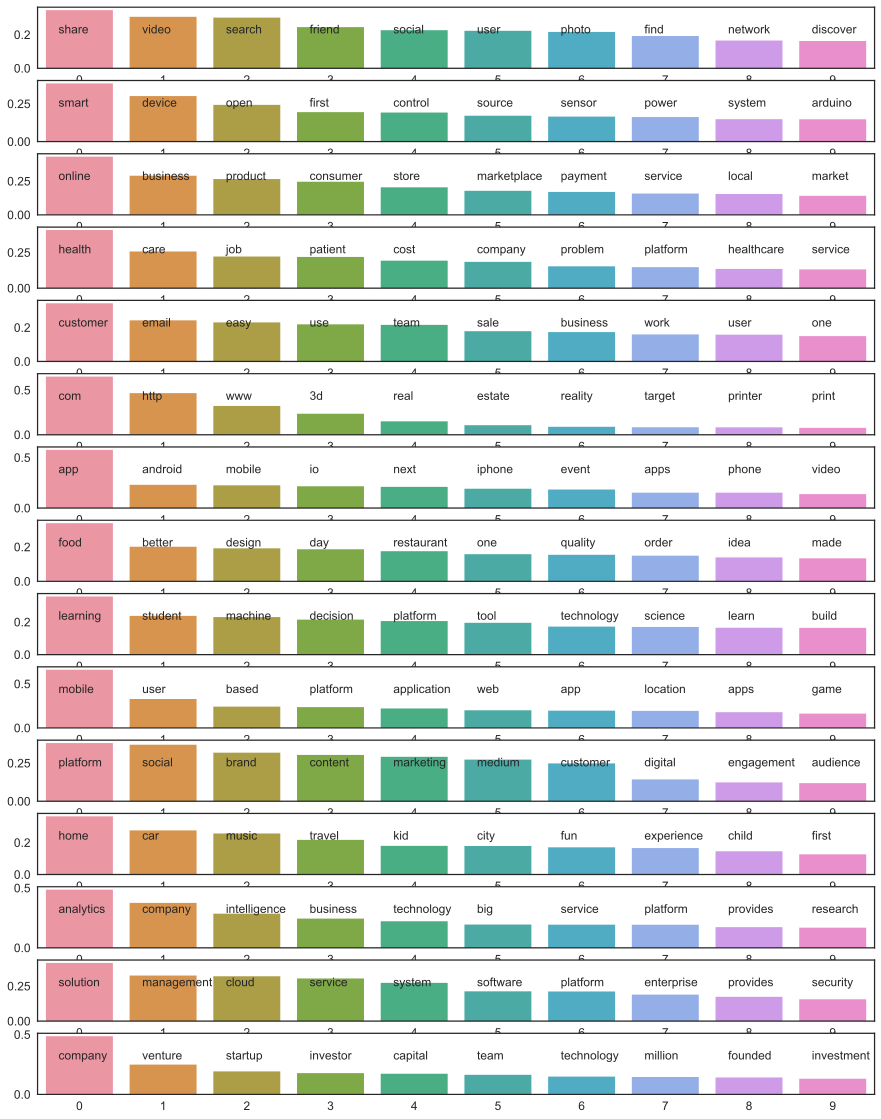

In [9]:
fig=figure(figsize=(15,20))
for i in range(15):
    subplot(15,1,i+1)
    plot_top_words(lda,tf_feature_names,i)

In [10]:
import itertools
palette = itertools.cycle(sns.hls_palette(15))
markers= itertools.cycle(['x','o','v','^','<','s'])
from sklearn import metrics
from sklearn.metrics import pairwise_distances

In [11]:
def plot_cluster(model, features, tsne_features, feature_names, nmf_model=lda):
    """
    model: the clustering model. model.labels_ should contain the clusting label
    features: feature vectors used to compute the clustering centroid
    tsne_features: feature vectors for plot with tsne
    """
    cluster_labels=model.labels_
    n_top_words=10
    num_clusters=max(cluster_labels)+1
    # plotting
    # sample 2000 data points for scattering plot
    sample_for_plt, label_for_plt=resample(tsne_features,cluster_labels,n_samples=2000,random_state=0)
    mapping = TSNE(n_components=2,init='random', random_state=0, n_iter=2000, verbose=0, learning_rate=100, perplexity=20)
    embed=mapping.fit_transform(sample_for_plt)
    fig=figure(figsize=(15,7))
    # plot the clusters
    subplot(1,2,1)
    for i in range(num_clusters):
        subgroup=embed[label_for_plt==i,:]
        scatter(subgroup[:,0],subgroup[:,1],s=15, color=next(palette), marker=next(markers), label='{}'.format(i))
    legend()
    # plot the histgram of the clusters 
    subplot(1,2,2)
    hist(cluster_labels)
    # print out the cluster centers
    fig=figure(figsize=(15,10))
    for i in range(max(cluster_labels)+1):
        cluster=features[cluster_labels==i,:]
        centroid=np.mean(cluster,axis=0)
        centroid_feature=centroid.dot(nmf_model.components_)
        sorted_idx=centroid_feature.argsort()[:-n_top_words - 1:-1]
        subplot(num_clusters,1,i+1)
        ax = sns.barplot(x=range(10),y=centroid_feature[sorted_idx])
        top_words=[feature_names[j] for j in sorted_idx]
        word_id=0
        height= max(centroid_feature[sorted_idx])*0.6
        for p in ax.patches:
            ax.text(p.get_x()+0.15, height, '{}'.format(top_words[word_id]))
            word_id+=1
def print_cluster_member(model, cluster_id, data, num_samples=10):
    cluster_member=data.iloc[model.labels_==cluster_id]
    print 'number of companies in this class:', len(cluster_member)
    for m in cluster_member.head(num_samples).iterrows():
        print 'company ID:', m[0]
        print m[1]['Description']


In [12]:
# agglomerative clustering

In [13]:
from sklearn.cluster import AgglomerativeClustering

In [14]:
agg= AgglomerativeClustering(n_clusters=20, linkage='ward')
agg.fit(topic_feature_norm)
metrics.calinski_harabaz_score(topic_feature_norm, agg.labels_) 

1712.2216559611225

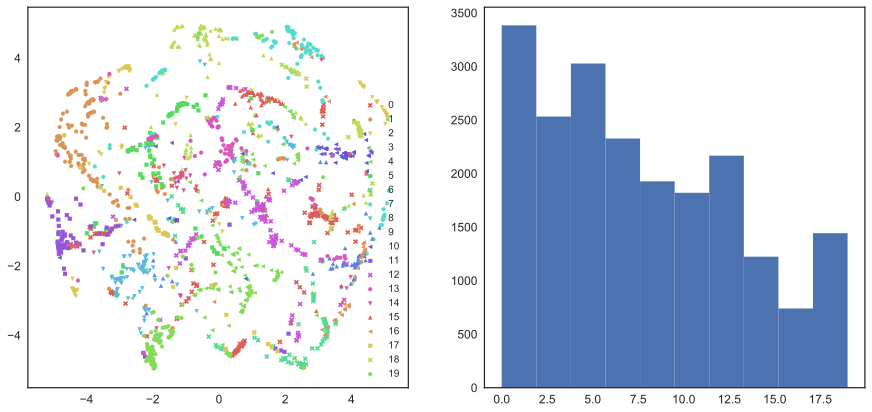

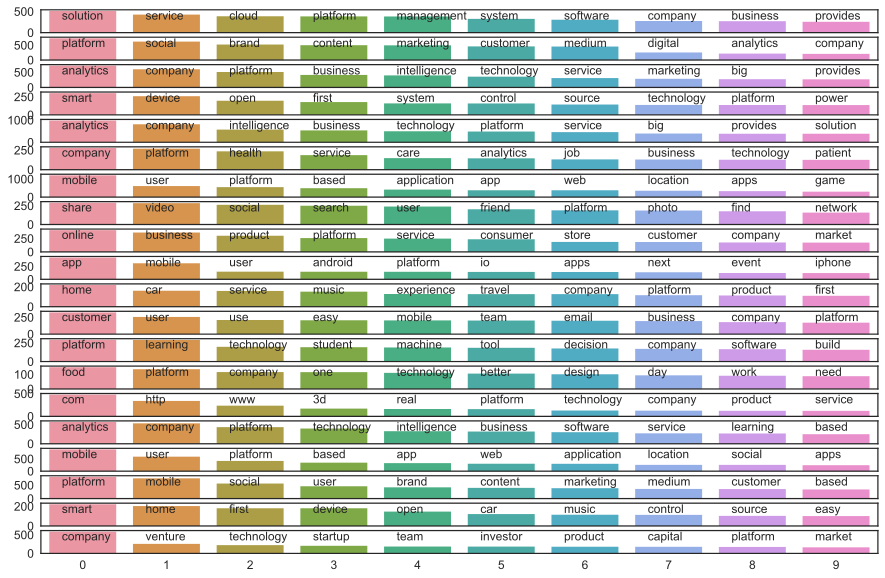

In [15]:
plot_cluster(agg, topic_feature, topic_feature_norm, tf_feature_names)

In [16]:
print_cluster_member(agg, 1, merge_data, 15)

number of companies in this class: 1878
company ID: 0
Krux helps marketers, publishers and agencies drive revenue by delivering smarter content, commerce and marketing experiences.
company ID: 7
Qubit gives marketers the tools to understand their visitors, and personalize their online presence to drive conversions in real time.
company ID: 10
Nanigans advertising automation software powers the world’s leading in-house performance marketing teams.
company ID: 11
Footwear and apparel’s discovery platform
company ID: 13
Flyby Media develops next-generation consumer mobile social applications that connect the physical world with digital content.
company ID: 17
Simply Measured provides social media analytics and measurements for data-driven agencies and brands.
company ID: 22
MyLikes is the World's Largest Social Website Network. MyLikes drives traffic to content by empowering publishers to monetize their stream.
company ID: 29
SimpleReach is the standard in content measurement and distribu

In [17]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(20, 0.4)
neigh.fit(topic_feature_norm) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=0.4)

In [18]:
def query_company(id, knn_model=neigh, data_set=merge_data, X=topic_feature_norm):
    k=10
    print 'query id:', id
    print data_set.iloc[id]['Description']
    print '-'*50
    distances, indices = knn_model.kneighbors(X[id].reshape(1, -1),n_neighbors=k)
    for i in range(1,k):
        print '{}st neighbor: id {}, with distance {}'.format(i,indices[0][i],distances[0][i])
        print  data_set.iloc[indices[0][i]]['Description']
        print 

In [19]:
query_company(3)

query id: 3
Quid powers human intuition with machine intelligence, enabling organizations to make decisions that matter.
--------------------------------------------------
1st neighbor: id 9628, with distance 0.00733536571026
To give data scientists and Big Data engineers the best learning experience and the most productive development platform

2st neighbor: id 17269, with distance 0.0115255644716
Koality is a continuous integration platform that parallelizes your test suites, prevents broken builds, and works behind your firewall.

3st neighbor: id 6695, with distance 0.0119853000533
Created by Dataiku, Data Science Studio (DSS) is the tool that lets data scientists and analysts do machine learning on any (dirty) data.

4st neighbor: id 10820, with distance 0.0203300879199
PicoCluster is a new learning tool designed to teach students and professionals how to use and program Big Data and distributed software.

5st neighbor: id 7254, with distance 0.0230281424189
Humintio is a gamified